In [18]:
from pathlib import Path

import random, json, math, time, yaml, collections, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
from tqdm import tqdm

import timm  # SOTA image models

In [46]:
DATA_ROOT          = Path("/media/dtsarev/SatSSD/data")
FACES_DIR          = DATA_ROOT / "face_images"
TRAIN_SPLIT_CSV    = DATA_ROOT / "train_split.csv"
VAL_SPLIT_CSV      = DATA_ROOT / "valid_split.csv"

BACKBONE_NAME      = "tf_efficientnet_b0_ns"   # timm name of the image backbone
EMBED_OUT_DIM      = 1280                      # depends on backbone
IMG_SIZE           = 224
IMG_BATCH_SIZE     = 64                        # batch for forward pass of faces
EXTRACT_NUM_WORKERS= 4

REGRESSOR_HIDDEN   = 512
TRAIN_BATCH_SIZE   = 256
NUM_EPOCHS         = 40
LEARNING_RATE      = 3e-4
WEIGHT_DECAY       = 1e-4
EARLY_STOP_PATIENCE= 10
SEED               = 42

SKIP_MISSING_EMB   = True

In [47]:
EMOTIONS = [
    "Admiration", "Amusement", "Determination",
    "Empathic Pain", "Excitement", "Joy"
]
NUM_CLASSES = len(EMOTIONS)

EMBED_CACHE_DIR    = Path("cached_embeddings_img")  # will be created

In [48]:
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [49]:
def pearson_corr_torch(preds: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    """Differentiable Pearson correlation averaged over columns."""
    vx = preds - preds.mean(0)
    vy = targets - targets.mean(0)
    corr = (vx * vy).sum(0) / (torch.sqrt((vx**2).sum(0) * (vy**2).sum(0)) + 1e-8)
    return corr.mean()

class PearsonLoss(nn.Module):
    def forward(self, preds: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        return 1.0 - pearson_corr_torch(preds, targets)

In [50]:
transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

@torch.no_grad()
def extract_embeddings_for_video(video_dir: Path, model: nn.Module) -> np.ndarray:
    """Return mean embedding for all .jpg files inside *video_dir*."""
    model.eval()
    imgs = sorted(video_dir.glob("*.jpg"))
    if len(imgs) == 0:
        raise RuntimeError(f"No .jpg files in {video_dir}")
    loader = DataLoader(imgs, batch_size=IMG_BATCH_SIZE, num_workers=EXTRACT_NUM_WORKERS,
                        collate_fn=lambda batch: [transform(Image.open(p).convert("RGB")) for p in batch])
    feats = []
    for batch in loader:
        batch = torch.stack(batch).to(device, non_blocking=True)
        emb = model(batch)
        feats.append(emb.cpu())
    feats = torch.cat(feats, 0)
    return feats.mean(0).numpy()

In [51]:
backbone = timm.create_model(BACKBONE_NAME, pretrained=True, num_classes=0)  # feature extractor
backbone.to(device)

EMBED_CACHE_DIR.mkdir(exist_ok=True)

/home/dtsarev/master_of_cv/DIPLOM/repos/venv/lib/python3.10/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


In [52]:
def build_embedding_cache(force: bool=False):
    """Compute and store mean embeddings as .npy; skip if cached."""
    for video_dir in tqdm(sorted(FACES_DIR.iterdir())):
        if not video_dir.is_dir():
            continue
        out_file = EMBED_CACHE_DIR / f"{video_dir.name}.npy"
        if out_file.exists() and not force:
            continue
        try:
            emb = extract_embeddings_for_video(video_dir, backbone)
            np.save(out_file, emb)
        except Exception as e:
            print(f"✗ Failed {video_dir}: {e}")
    print("✔ Finished embedding cache generation")

# Uncomment to (re)build
#build_embedding_cache()

In [53]:
class VideoEmbeddingDataset(Dataset):
    def __init__(self, csv_path: Path, skip_missing: bool = SKIP_MISSING_EMB):
        df = pd.read_csv(csv_path, dtype={"Filename": str})
        raw_ids     = df["Filename"].tolist()
        raw_targets = df[EMOTIONS].values.astype(np.float32)

        ids, targets = [], []
        for vid, tgt in zip(raw_ids, raw_targets):
            if (EMBED_CACHE_DIR / f"{vid}.npy").exists():
                ids.append(vid)
                targets.append(tgt)
            elif not skip_missing:
                raise FileNotFoundError(f"Missing embedding for {vid}. Run build_embedding_cache().")
            # else silently drop
        if len(ids) == 0:
            raise RuntimeError("Dataset is empty after skipping missing embeddings.")
        self.ids      = ids
        self.targets  = np.stack(targets)
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        vid = self.ids[idx]
        emb = np.load(EMBED_CACHE_DIR / f"{vid}.npy")
        return torch.from_numpy(emb).float(), torch.from_numpy(self.targets[idx])

def make_loaders():
    train_ds = VideoEmbeddingDataset(TRAIN_SPLIT_CSV)
    val_ds   = VideoEmbeddingDataset(VAL_SPLIT_CSV)
    train_loader = DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_ds,   batch_size=TRAIN_BATCH_SIZE, shuffle=False)
    return train_loader, val_loader

In [54]:
class Regressor(nn.Module):
    def __init__(self, in_features:int=EMBED_OUT_DIM):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, REGRESSOR_HIDDEN),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(REGRESSOR_HIDDEN, NUM_CLASSES),
            nn.Sigmoid()  # outputs in [0,1]
        )
    def forward(self, x):
        return self.net(x)

In [55]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    epoch_loss, epoch_metric, n = 0.0, 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(x)
        loss  = criterion(preds, y)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            metric = pearson_corr_torch(preds, y)
        bs = x.size(0)
        epoch_loss   += loss.item() * bs
        epoch_metric += metric.item() * bs
        n += bs
    return epoch_loss / n, epoch_metric / n

def eval_epoch(model, loader, criterion):
    model.eval()
    epoch_loss, epoch_metric, n = 0.0, 0.0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            loss  = criterion(preds, y)
            metric = pearson_corr_torch(preds, y)
            bs = x.size(0)
            epoch_loss   += loss.item() * bs
            epoch_metric += metric.item() * bs
            n += bs
    return epoch_loss / n, epoch_metric / n

In [56]:
def train():
    train_loader, val_loader = make_loaders()
    model     = Regressor().to(device)
    criterion = PearsonLoss()
    optim     = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, patience=5)

    history = {"train_loss":[], "val_loss":[], "train_r":[], "val_r":[]}
    best_val_r, patience = -1e9, 0

    for epoch in range(1, NUM_EPOCHS+1):
        t_loss, t_r = train_epoch(model, train_loader, optim, criterion)
        v_loss, v_r = eval_epoch(model, val_loader,   criterion)
        scheduler.step(v_loss)

        history["train_loss"].append(t_loss)
        history["val_loss"].append(v_loss)
        history["train_r"].append(t_r)
        history["val_r"].append(v_r)

        print(f"Epoch {epoch:02d}/{NUM_EPOCHS} | "
              f"train: loss {t_loss:.4f}  r {t_r:.4f} | "
              f"val: loss {v_loss:.4f}  r {v_r:.4f}")

        # Early stopping ----------------------------------------------------
        if v_r > best_val_r + 1e-4:
            best_val_r = v_r
            best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}
            patience = 0
        else:
            patience += 1
            if patience >= EARLY_STOP_PATIENCE:
                print("Early stop")
                break

    model.load_state_dict(best_state)
    return model, history, val_loader

In [57]:
def plot_history(history: Dict[str, List[float]]):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history["train_loss"], label="train")
    plt.plot(history["val_loss"],   label="val")
    plt.title("Loss (1 - Pearson)")
    plt.xlabel("epoch"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history["train_r"], label="train")
    plt.plot(history["val_r"],   label="val")
    plt.title("Mean Pearson R")
    plt.xlabel("epoch"); plt.legend()
    plt.tight_layout(); plt.show()

In [58]:
def per_emotion_r(model:nn.Module, loader):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            all_preds.append(preds.cpu())
            all_targets.append(y.cpu())
    preds   = torch.cat(all_preds)
    targets = torch.cat(all_targets)
    vx = preds - preds.mean(0)
    vy = targets - targets.mean(0)
    corr = (vx * vy).sum(0) / (torch.sqrt((vx**2).sum(0) * (vy**2).sum(0)) + 1e-8)
    return corr.numpy()

In [59]:
model, hist, val_loader = train()

Epoch 01/40 | train: loss 0.9592  r 0.0408 | val: loss 0.9710  r 0.0290
Epoch 02/40 | train: loss 0.8982  r 0.1018 | val: loss 0.9575  r 0.0425
Epoch 03/40 | train: loss 0.8567  r 0.1433 | val: loss 0.9542  r 0.0458
Epoch 04/40 | train: loss 0.8186  r 0.1814 | val: loss 0.9450  r 0.0550
Epoch 05/40 | train: loss 0.7879  r 0.2121 | val: loss 0.9393  r 0.0607
Epoch 06/40 | train: loss 0.7656  r 0.2344 | val: loss 0.9344  r 0.0656
Epoch 07/40 | train: loss 0.7320  r 0.2680 | val: loss 0.9334  r 0.0666
Epoch 08/40 | train: loss 0.7156  r 0.2844 | val: loss 0.9319  r 0.0681
Epoch 09/40 | train: loss 0.6929  r 0.3071 | val: loss 0.9343  r 0.0657
Epoch 10/40 | train: loss 0.6726  r 0.3274 | val: loss 0.9285  r 0.0715
Epoch 11/40 | train: loss 0.6583  r 0.3417 | val: loss 0.9288  r 0.0712
Epoch 12/40 | train: loss 0.6395  r 0.3605 | val: loss 0.9290  r 0.0710
Epoch 13/40 | train: loss 0.6280  r 0.3720 | val: loss 0.9285  r 0.0715
Epoch 14/40 | train: loss 0.6139  r 0.3861 | val: loss 0.9309  r

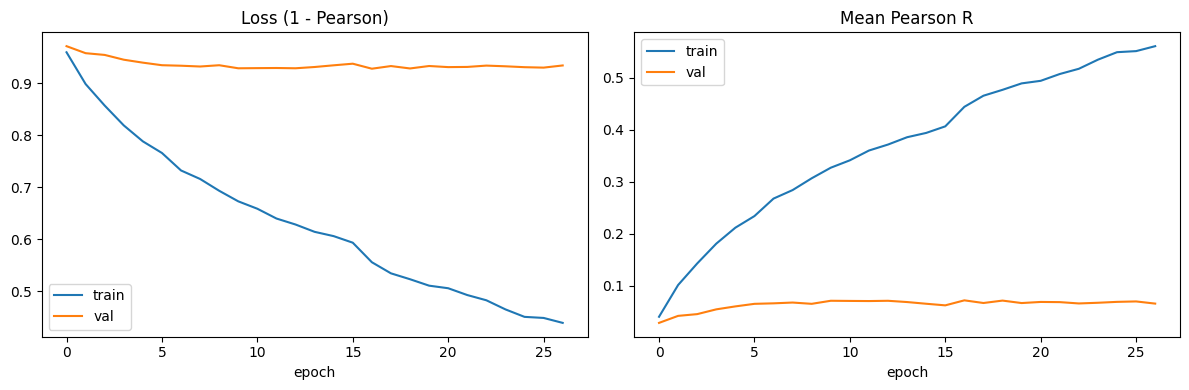

In [60]:
plot_history(hist)

In [63]:
class_r = per_emotion_r(model, val_loader)
for emo, r in zip(EMOTIONS, class_r):
    print(f"{emo:<15} Pearson r: {r:.4f}")
print("Mean r:", class_r.mean())

Admiration      Pearson r: 0.0019
Amusement       Pearson r: 0.0863
Determination   Pearson r: 0.0502
Empathic Pain   Pearson r: 0.0941
Excitement      Pearson r: 0.0842
Joy             Pearson r: 0.1171
Mean r: 0.07228697


In [62]:
torch.save({"state_dict": model.state_dict(),
            "backbone": BACKBONE_NAME,
            "img_size": IMG_SIZE}, DATA_ROOT/"emotion_regressor.pth")